# MovieLens 1M - Exploratory Data Analysis (EDA)

Date: 2025-12-05

## Objective
- Understand the dataset characteristics
- Identify patterns and insights
- Detect Cold Start problems
- Prepare for recommendation algorithm design

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import sys
sys.path.insert(0, '..')
from config import DB_CONFIG

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Database Connection

In [3]:
# Create database connection
conn_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
engine = create_engine(conn_string)

print(f"Connected to {DB_CONFIG['database']}")

Connected to movielens_db


## 2. Basic Statistics

In [4]:
# Get basic counts
with engine.connect() as conn:
    query = text("""
        SELECT 
            'Users' as entity,
            COUNT(*) as count
        FROM users
        UNION ALL
        SELECT 'Movies', COUNT(*) FROM movies
        UNION ALL
        SELECT 'Genres', COUNT(*) FROM genres
        UNION ALL
        SELECT 'Movie-Genre Relations', COUNT(*) FROM movie_genres
        UNION ALL
        SELECT 'Ratings', COUNT(*) FROM ratings
    """)
    
    counts_df = pd.read_sql(query, conn)

print("\n=== Dataset Overview ===")
print(counts_df.to_string(index=False))


=== Dataset Overview ===
               entity   count
                Users    6040
               Movies    3883
               Genres      18
Movie-Genre Relations    6408
              Ratings 1000209


## 3. Rating Distribution Analysis


=== Rating Distribution ===
 rating  count  percentage
    1.0  56174        5.62
    2.0 107557       10.75
    3.0 261197       26.11
    4.0 348971       34.89
    5.0 226310       22.63


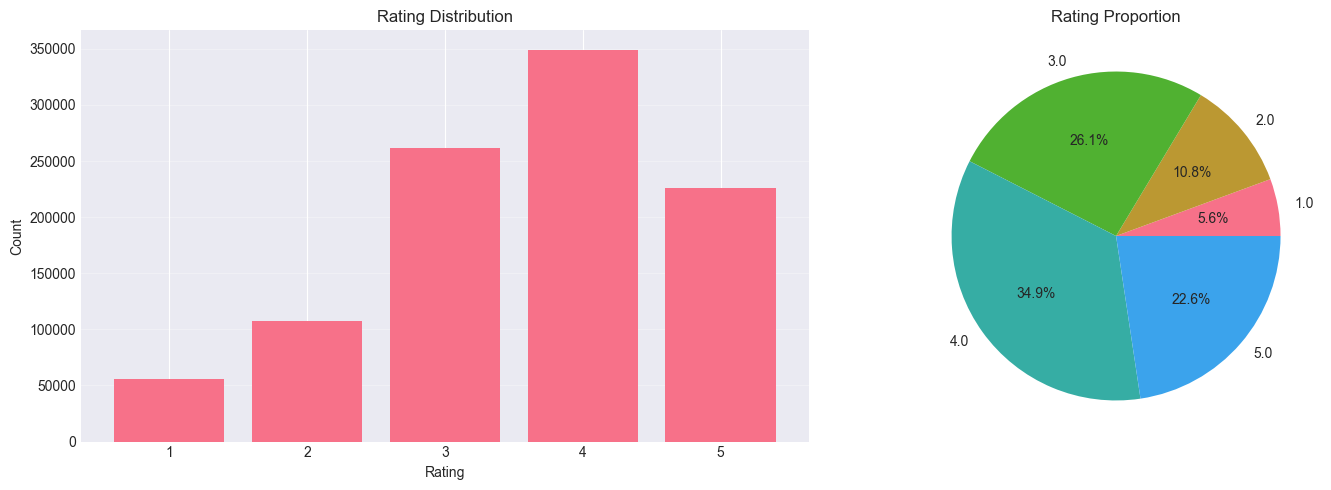


=== Rating Statistics ===
 mean_rating  median_rating  std_rating  min_rating  max_rating
    3.581564            4.0    1.117102         1.0         5.0


In [5]:
# Load rating distribution
with engine.connect() as conn:
    query = text("""
        SELECT 
            rating,
            COUNT(*) as count,
            ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
        FROM ratings
        GROUP BY rating
        ORDER BY rating
    """)
    
    rating_dist_df = pd.read_sql(query, conn)

print("\n=== Rating Distribution ===")
print(rating_dist_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart
axes[0].bar(rating_dist_df['rating'], rating_dist_df['count'])
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].set_title('Rating Distribution')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(rating_dist_df['count'], labels=rating_dist_df['rating'], autopct='%1.1f%%')
axes[1].set_title('Rating Proportion')

plt.tight_layout()
plt.show()

# Statistics
with engine.connect() as conn:
    query = text("""
        SELECT 
            AVG(rating) as mean_rating,
            PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY rating) as median_rating,
            STDDEV(rating) as std_rating,
            MIN(rating) as min_rating,
            MAX(rating) as max_rating
        FROM ratings
    """)
    
    stats_df = pd.read_sql(query, conn)

print("\n=== Rating Statistics ===")
print(stats_df.to_string(index=False))

## 4. User Activity Analysis


=== User Activity Statistics ===
count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: rating_count, dtype: float64


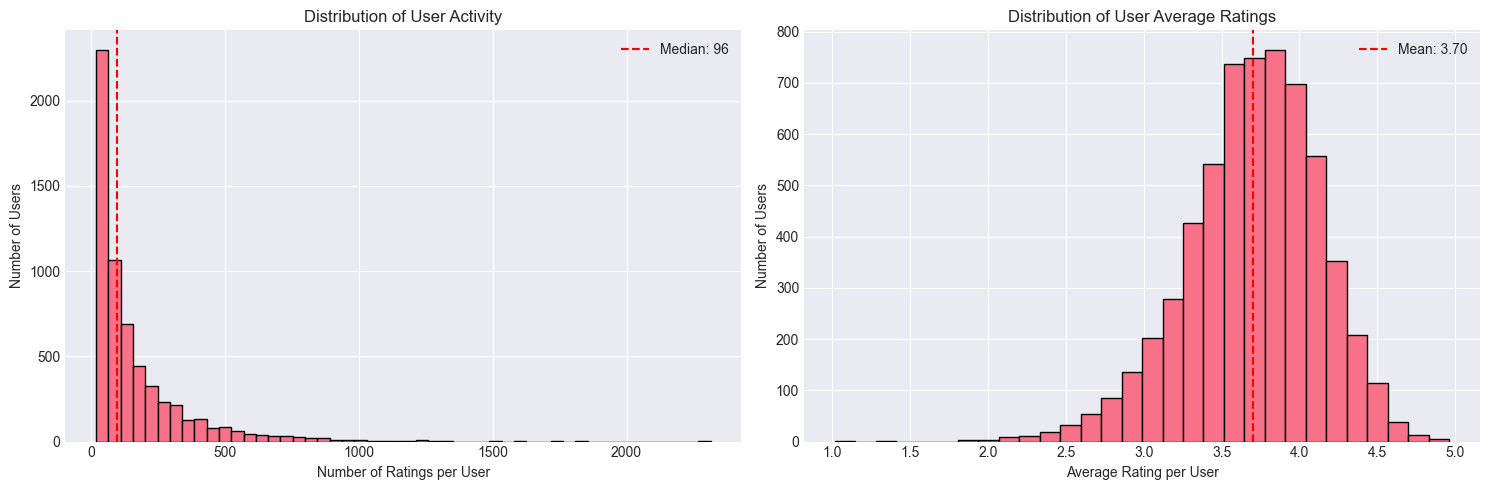

In [6]:
# Ratings per user
with engine.connect() as conn:
    query = text("""
        SELECT 
            user_id,
            COUNT(*) as rating_count,
            AVG(rating) as avg_rating
        FROM ratings
        GROUP BY user_id
    """)
    
    user_activity_df = pd.read_sql(query, conn)

print("\n=== User Activity Statistics ===")
print(user_activity_df['rating_count'].describe())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of ratings per user
axes[0].hist(user_activity_df['rating_count'], bins=50, edgecolor='black')
axes[0].set_xlabel('Number of Ratings per User')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of User Activity')
axes[0].axvline(user_activity_df['rating_count'].median(), color='red', linestyle='--', label=f'Median: {user_activity_df["rating_count"].median():.0f}')
axes[0].legend()

# Average rating distribution per user
axes[1].hist(user_activity_df['avg_rating'], bins=30, edgecolor='black')
axes[1].set_xlabel('Average Rating per User')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Distribution of User Average Ratings')
axes[1].axvline(user_activity_df['avg_rating'].mean(), color='red', linestyle='--', label=f'Mean: {user_activity_df["avg_rating"].mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Movie Popularity Analysis


=== Movie Popularity Statistics ===
count    3883.000000
mean      257.586660
std       379.391042
min         0.000000
25%        26.000000
50%       109.000000
75%       330.000000
max      3428.000000
Name: rating_count, dtype: float64

=== Top 20 Most Rated Movies ===
                                         title  rating_count  avg_rating
                               American Beauty          3428    4.317386
            Star Wars: Episode IV - A New Hope          2991    4.453694
Star Wars: Episode V - The Empire Strikes Back          2990    4.292977
    Star Wars: Episode VI - Return of the Jedi          2883    4.022893
                                 Jurassic Park          2672    3.763847
                           Saving Private Ryan          2653    4.337354
                    Terminator 2: Judgment Day          2649    4.058513
                                   Matrix, The          2590    4.315830
                            Back to the Future          2583    3.990

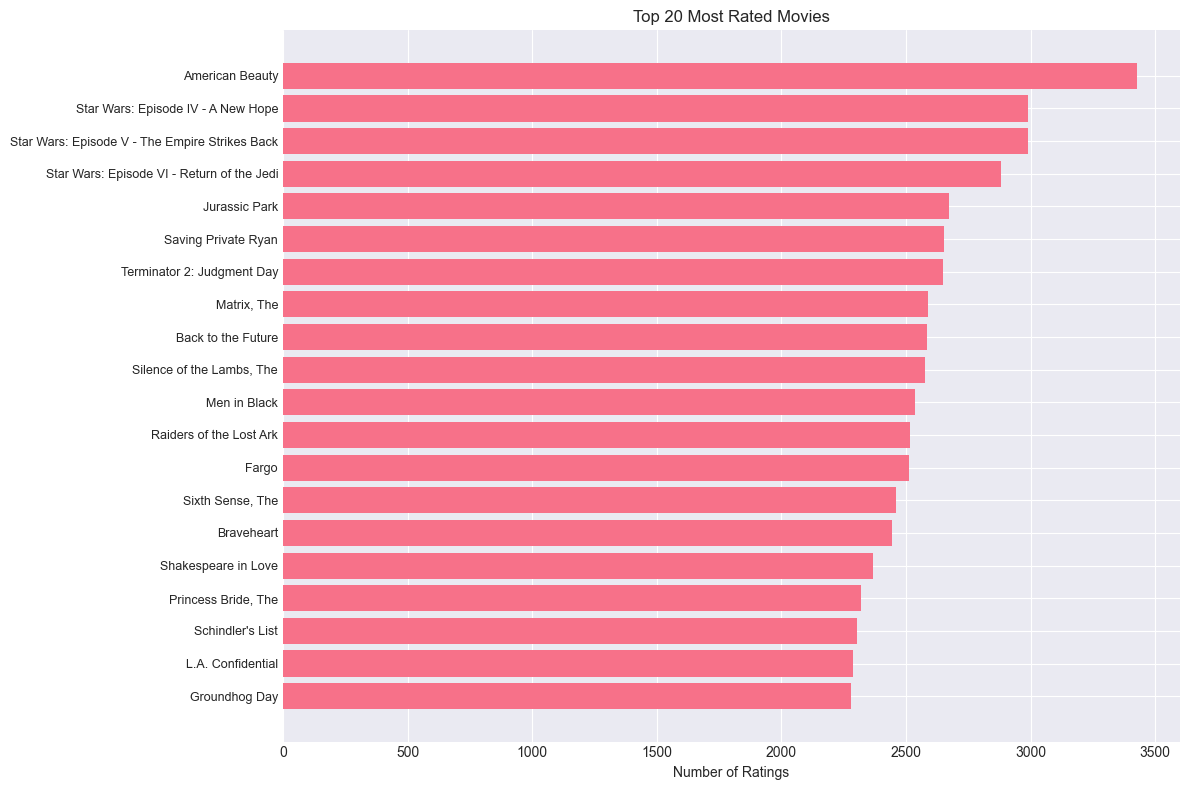

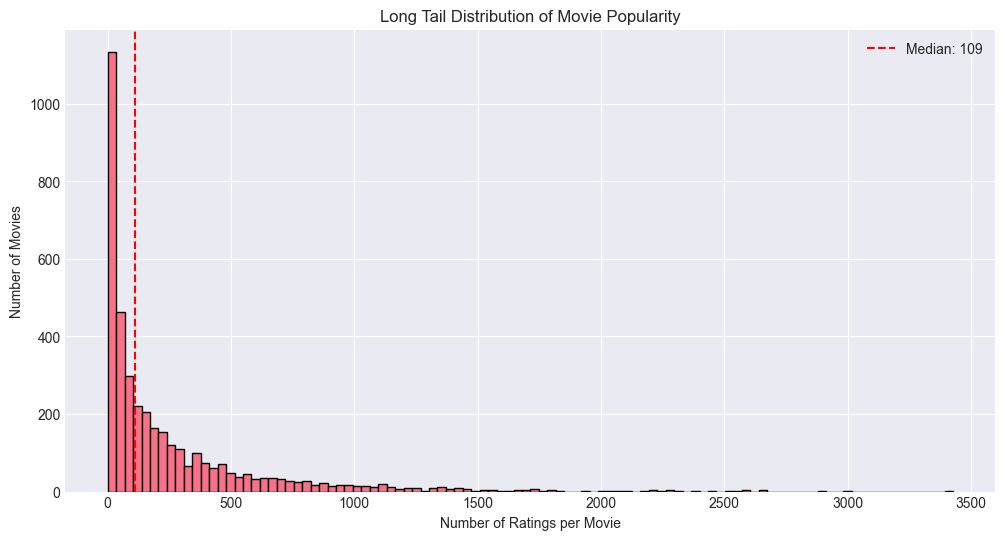


Movies with < 5 ratings: 467 (12.0%)


In [7]:
# Ratings per movie
with engine.connect() as conn:
    query = text("""
        SELECT 
            m.movie_id,
            m.title,
            COUNT(r.rating_id) as rating_count,
            AVG(r.rating) as avg_rating
        FROM movies m
        LEFT JOIN ratings r ON m.movie_id = r.movie_id
        GROUP BY m.movie_id, m.title
    """)
    
    movie_popularity_df = pd.read_sql(query, conn)

print("\n=== Movie Popularity Statistics ===")
print(movie_popularity_df['rating_count'].describe())

# Top 20 most rated movies
top_movies = movie_popularity_df.nlargest(20, 'rating_count')
print("\n=== Top 20 Most Rated Movies ===")
print(top_movies[['title', 'rating_count', 'avg_rating']].to_string(index=False))

# Visualization
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_movies)), top_movies['rating_count'])
plt.yticks(range(len(top_movies)), top_movies['title'], fontsize=9)
plt.xlabel('Number of Ratings')
plt.title('Top 20 Most Rated Movies')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Long Tail analysis
plt.figure(figsize=(12, 6))
plt.hist(movie_popularity_df['rating_count'], bins=100, edgecolor='black')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Number of Movies')
plt.title('Long Tail Distribution of Movie Popularity')
plt.axvline(movie_popularity_df['rating_count'].median(), color='red', linestyle='--', label=f'Median: {movie_popularity_df["rating_count"].median():.0f}')
plt.legend()
plt.show()

# Movies with few ratings (Cold Start)
cold_start_threshold = 5
cold_movies = movie_popularity_df[movie_popularity_df['rating_count'] < cold_start_threshold]
print(f"\nMovies with < {cold_start_threshold} ratings: {len(cold_movies)} ({len(cold_movies)/len(movie_popularity_df)*100:.1f}%)")

## 6. Genre Analysis


=== Genre Statistics ===
 genre_name  movie_count  rating_count  avg_rating
     Comedy         1200        356580    3.522099
      Drama         1603        354529    3.766332
     Action          503        257457    3.491185
   Thriller          492        189680    3.570466
     Sci-Fi          276        157294    3.466521
    Romance          471        147523    3.607465
  Adventure          283        133953    3.477257
      Crime          211         79541    3.708679
     Horror          343         76386    3.215013
 Children's          251         72186    3.422035
        War          143         68527    3.893327
  Animation          105         43293    3.684868
    Musical          114         41533    3.665519
    Mystery          106         40178    3.668102
    Fantasy           68         36301    3.447371
    Western           68         20683    3.637770
  Film-Noir           44         18261    4.075188
Documentary          127          7910    3.933123


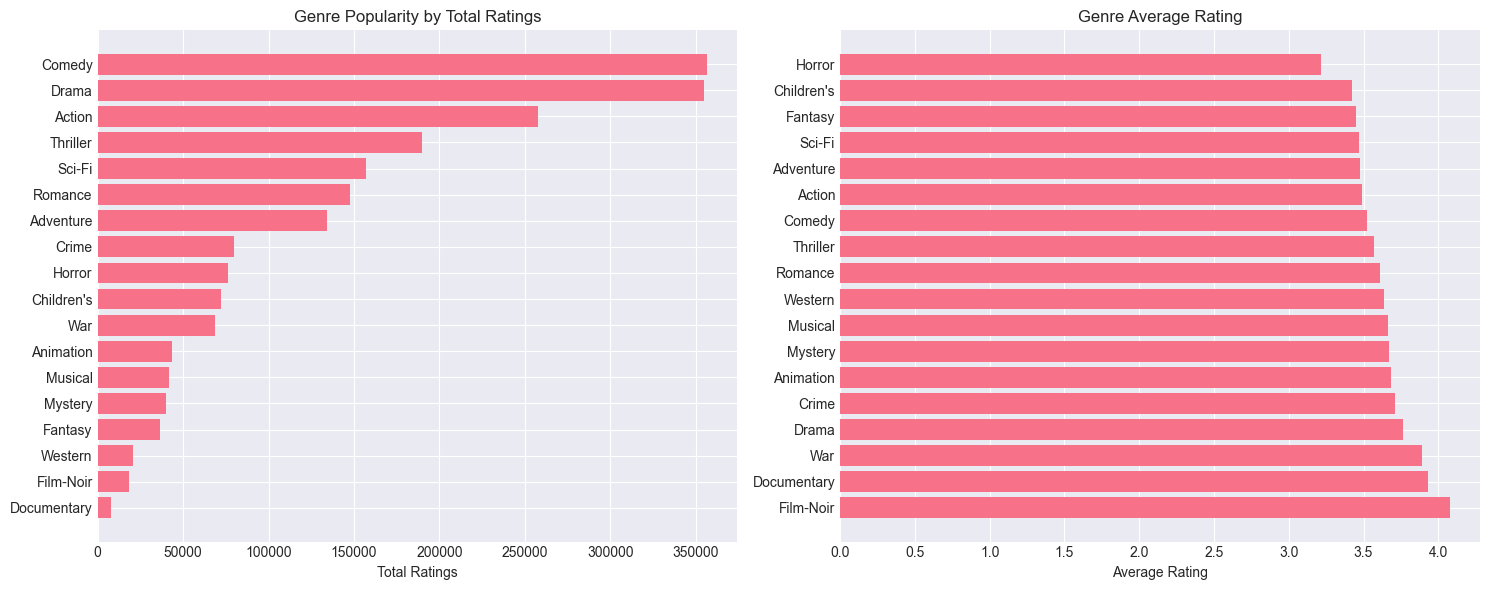

In [8]:
# Genre popularity
with engine.connect() as conn:
    query = text("""
        SELECT 
            g.genre_name,
            COUNT(DISTINCT mg.movie_id) as movie_count,
            COUNT(r.rating_id) as rating_count,
            AVG(r.rating) as avg_rating
        FROM genres g
        JOIN movie_genres mg ON g.genre_id = mg.genre_id
        LEFT JOIN ratings r ON mg.movie_id = r.movie_id
        GROUP BY g.genre_name
        ORDER BY rating_count DESC
    """)
    
    genre_df = pd.read_sql(query, conn)

print("\n=== Genre Statistics ===")
print(genre_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Genre popularity by rating count
axes[0].barh(range(len(genre_df)), genre_df['rating_count'])
axes[0].set_yticks(range(len(genre_df)))
axes[0].set_yticklabels(genre_df['genre_name'])
axes[0].set_xlabel('Total Ratings')
axes[0].set_title('Genre Popularity by Total Ratings')
axes[0].invert_yaxis()

# Genre average rating
genre_sorted = genre_df.sort_values('avg_rating', ascending=True)
axes[1].barh(range(len(genre_sorted)), genre_sorted['avg_rating'])
axes[1].set_yticks(range(len(genre_sorted)))
axes[1].set_yticklabels(genre_sorted['genre_name'])
axes[1].set_xlabel('Average Rating')
axes[1].set_title('Genre Average Rating')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Temporal Analysis

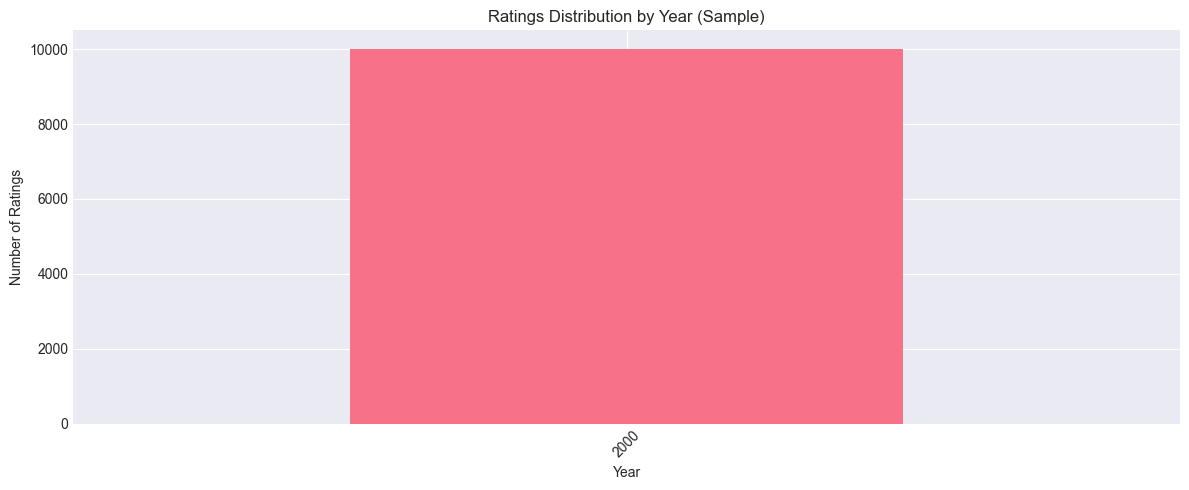


=== Temporal Coverage ===
Earliest rating: 2000-04-25 23:05:32+00:00
Latest rating: 2000-04-29 16:36:41+00:00


In [9]:
# Ratings over time
with engine.connect() as conn:
    query = text("""
        SELECT 
            TO_TIMESTAMP(timestamp) as rating_time,
            rating
        FROM ratings
        ORDER BY timestamp
        LIMIT 10000
    """)
    
    temporal_df = pd.read_sql(query, conn)

temporal_df['rating_time'] = pd.to_datetime(temporal_df['rating_time'])
temporal_df['year'] = temporal_df['rating_time'].dt.year
temporal_df['month'] = temporal_df['rating_time'].dt.month

# Ratings by year
yearly_counts = temporal_df.groupby('year').size()

plt.figure(figsize=(12, 5))
yearly_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.title('Ratings Distribution by Year (Sample)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n=== Temporal Coverage ===")
print(f"Earliest rating: {temporal_df['rating_time'].min()}")
print(f"Latest rating: {temporal_df['rating_time'].max()}")

## 8. Release Year Analysis

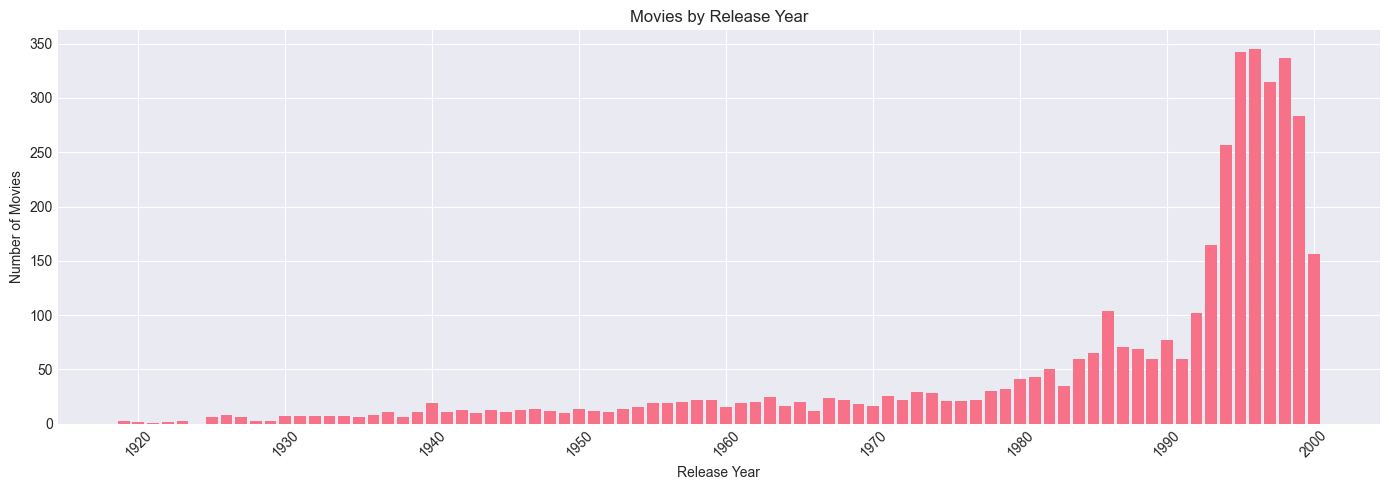


Year range: 1919 - 2000


In [10]:
# Movies by release year
with engine.connect() as conn:
    query = text("""
        SELECT 
            release_year,
            COUNT(*) as movie_count
        FROM movies
        WHERE release_year IS NOT NULL
        GROUP BY release_year
        ORDER BY release_year
    """)
    
    release_year_df = pd.read_sql(query, conn)

plt.figure(figsize=(14, 5))
plt.bar(release_year_df['release_year'], release_year_df['movie_count'])
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Movies by Release Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nYear range: {release_year_df['release_year'].min()} - {release_year_df['release_year'].max()}")

## 9. Cold Start Problem Analysis

In [11]:
# User Cold Start
print("=== User Cold Start Analysis ===")
user_rating_counts = user_activity_df['rating_count'].value_counts().sort_index()

thresholds = [0, 5, 10, 20, 50]
for i in range(len(thresholds)-1):
    low = thresholds[i]
    high = thresholds[i+1]
    count = user_activity_df[(user_activity_df['rating_count'] > low) & (user_activity_df['rating_count'] <= high)].shape[0]
    pct = count / len(user_activity_df) * 100
    print(f"Users with {low+1}-{high} ratings: {count} ({pct:.1f}%)")

high = thresholds[-1]
count = user_activity_df[user_activity_df['rating_count'] > high].shape[0]
pct = count / len(user_activity_df) * 100
print(f"Users with >{high} ratings: {count} ({pct:.1f}%)")

# Movie Cold Start
print("\n=== Movie Cold Start Analysis ===")
thresholds = [0, 5, 10, 20, 50]
for i in range(len(thresholds)-1):
    low = thresholds[i]
    high = thresholds[i+1]
    count = movie_popularity_df[(movie_popularity_df['rating_count'] > low) & (movie_popularity_df['rating_count'] <= high)].shape[0]
    pct = count / len(movie_popularity_df) * 100
    print(f"Movies with {low+1}-{high} ratings: {count} ({pct:.1f}%)")

high = thresholds[-1]
count = movie_popularity_df[movie_popularity_df['rating_count'] > high].shape[0]
pct = count / len(movie_popularity_df) * 100
print(f"Movies with >{high} ratings: {count} ({pct:.1f}%)")

=== User Cold Start Analysis ===
Users with 1-5 ratings: 0 (0.0%)
Users with 6-10 ratings: 0 (0.0%)
Users with 11-20 ratings: 86 (1.4%)
Users with 21-50 ratings: 1707 (28.3%)
Users with >50 ratings: 4247 (70.3%)

=== Movie Cold Start Analysis ===
Movies with 1-5 ratings: 329 (8.5%)
Movies with 6-10 ratings: 144 (3.7%)
Movies with 11-20 ratings: 222 (5.7%)
Movies with 21-50 ratings: 512 (13.2%)
Movies with >50 ratings: 2499 (64.4%)


## 10. User Demographics Analysis

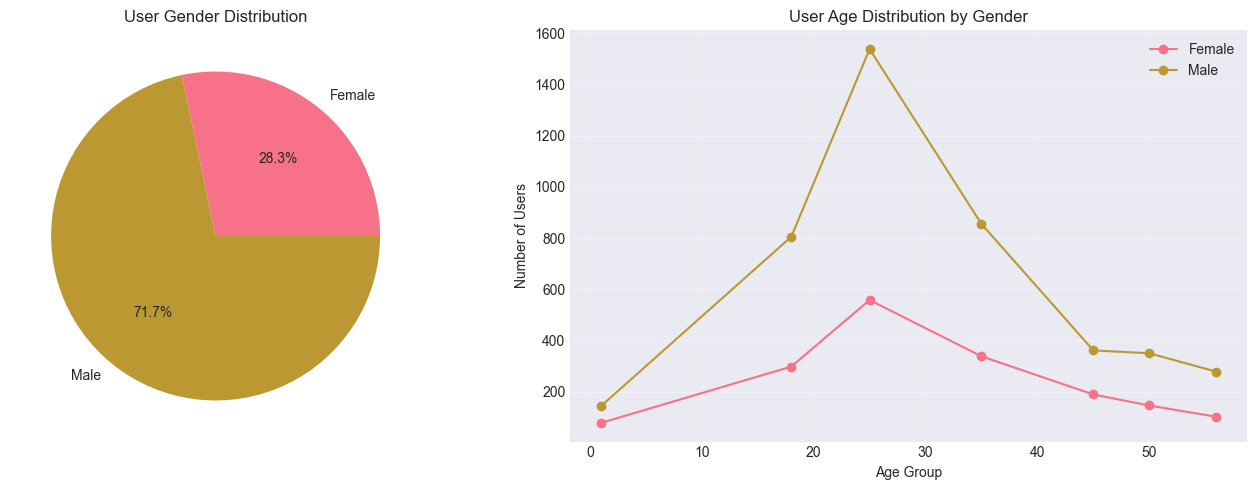

In [12]:
# User demographics
with engine.connect() as conn:
    query = text("""
        SELECT 
            gender,
            age,
            COUNT(*) as user_count
        FROM users
        GROUP BY gender, age
        ORDER BY gender, age
    """)
    
    demographics_df = pd.read_sql(query, conn)

# Gender distribution
gender_dist = demographics_df.groupby('gender')['user_count'].sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gender pie chart
axes[0].pie(gender_dist.values, labels=['Female' if g == 'F' else 'Male' for g in gender_dist.index], autopct='%1.1f%%')
axes[0].set_title('User Gender Distribution')

# Age distribution by gender
for gender in demographics_df['gender'].unique():
    subset = demographics_df[demographics_df['gender'] == gender]
    axes[1].plot(subset['age'], subset['user_count'], marker='o', label=f"{'Female' if gender == 'F' else 'Male'}")

axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('User Age Distribution by Gender')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Key Insights Summary

In [13]:
print("="*60)
print("KEY INSIGHTS FROM EDA")
print("="*60)

print("\n1. Dataset Size:")
print(f"   - {len(user_activity_df):,} users")
print(f"   - {len(movie_popularity_df):,} movies")
print(f"   - {user_activity_df['rating_count'].sum():,} ratings")

print("\n2. Rating Behavior:")
print(f"   - Average rating: {user_activity_df['avg_rating'].mean():.2f}")
print(f"   - Median ratings per user: {user_activity_df['rating_count'].median():.0f}")
print(f"   - Median ratings per movie: {movie_popularity_df['rating_count'].median():.0f}")

print("\n3. Cold Start Problem:")
cold_users = user_activity_df[user_activity_df['rating_count'] <= 5]
cold_movies = movie_popularity_df[movie_popularity_df['rating_count'] <= 5]
print(f"   - Users with ≤5 ratings: {len(cold_users)} ({len(cold_users)/len(user_activity_df)*100:.1f}%)")
print(f"   - Movies with ≤5 ratings: {len(cold_movies)} ({len(cold_movies)/len(movie_popularity_df)*100:.1f}%)")

print("\n4. Popular Genres:")
top_genres = genre_df.nlargest(3, 'rating_count')
for _, row in top_genres.iterrows():
    print(f"   - {row['genre_name']}: {row['rating_count']:,} ratings")

print("\n5. Data Sparsity:")
total_users = len(user_activity_df)
total_movies = len(movie_popularity_df)
total_ratings = user_activity_df['rating_count'].sum()
sparsity = 1 - (total_ratings / (total_users * total_movies))
print(f"   - Sparsity: {sparsity*100:.2f}%")
print(f"   - Density: {(1-sparsity)*100:.4f}%")

print("\n" + "="*60)

KEY INSIGHTS FROM EDA

1. Dataset Size:
   - 6,040 users
   - 3,883 movies
   - 1,000,209 ratings

2. Rating Behavior:
   - Average rating: 3.70
   - Median ratings per user: 96
   - Median ratings per movie: 109

3. Cold Start Problem:
   - Users with ≤5 ratings: 0 (0.0%)
   - Movies with ≤5 ratings: 506 (13.0%)

4. Popular Genres:
   - Comedy: 356,580 ratings
   - Drama: 354,529 ratings
   - Action: 257,457 ratings

5. Data Sparsity:
   - Sparsity: 95.74%
   - Density: 4.2647%



## Conclusion

This EDA reveals several important characteristics of the MovieLens 1M dataset:

1. **High sparsity**: The rating matrix is very sparse, which is typical for recommendation systems
2. **Cold Start challenges**: A significant portion of users and movies have few ratings
3. **Long Tail distribution**: Few movies are very popular, while many have few ratings
4. **Genre preferences**: Drama and Comedy are the most popular genres
5. **User diversity**: Users show varying levels of activity and rating patterns

These insights will guide our recommendation algorithm design in the following days.